In [1]:
import sys
sys.path.append("/home/ecbm4040/Final_Project/e4040-2021Fall-Project-SCNN-as6430-as6456-vsk2123/src/")

In [2]:
%load_ext autoreload
%autoreload 2

In [4]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import utils as np_utils
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, Dropout, BatchNormalization, Softmax
from tensorflow.keras import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import categorical_crossentropy
import datetime
from time import time
from matplotlib import pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.layers.pooling import GlobalAveragePooling2D


In [5]:
# CIFAR10 Dataset
from modules.utils import load_data
X_train, y_train = load_data(mode='train')
num_training = 49000
num_validation = 1000

X_val = X_train[-num_validation:, :]
y_val = y_train[-num_validation:]

X_train = X_train[:num_training, :]
y_train = y_train[:num_training]

# Preprocessing: subtract the mean value across every dimension for training data, and reshape it to be RGB size
mean_image = np.mean(X_train, axis=0)
X_train = X_train.astype(np.float32) - mean_image.astype(np.float32)
X_val = X_val.astype(np.float32) - mean_image

X_train = X_train.reshape(-1,3,32,32).transpose(0,2,3,1) / 255
X_val = X_val.reshape(-1,3,32,32).transpose(0,2,3,1) / 255

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)

y_train_dummy = tf.keras.utils.to_categorical(y_train)
y_val_dummy = tf.keras.utils.to_categorical(y_val)
print('Train labels shape (one-hot): ', y_train_dummy.shape)
print('Validation labels shape (one-hot): ', y_val_dummy.shape)


./data/cifar-10-python.tar.gz already exists. Begin extracting...
Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Train labels shape (one-hot):  (49000, 10)
Validation labels shape (one-hot):  (1000, 10)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


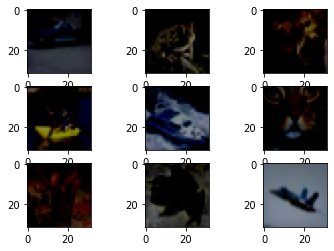

In [6]:
# Plot sample images
for i in range(0,9):
    plt.subplot(330 + 1 + i)
    plt.imshow(X_train[i])
plt.show()

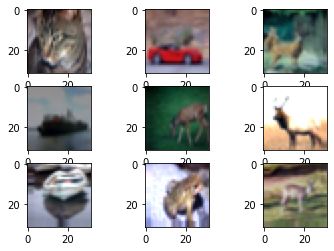

In [7]:
# Data augmentation code
import numpy as np
import random

def HSV_perturbations(image):
    choice=random.randint(1,3)
    print(choice)
    image = np.array(image)
    if choice ==1:
        return tf.image.random_hue(image, 1/random.randint(1,10))
    elif choice ==2:
        return tf.image.random_saturation(image, 5, 10)
    else:
        return image # so as to avoid not change hue for every image

datagen = ImageDataGenerator(
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.5,1.5]
    )
datagen.fit(X_train)

# Plot sample augmented images
for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size=9):
    for i in range(0, 9):
        plt.subplot(330 + 1 + i)
        plt.imshow(X_batch[i].astype(np.uint8))
    plt.show()
    break

In [9]:

def spatialCNN(input_shape):

    model = Sequential()

    model.add(Conv2D(96, kernel_size=(3,3),padding="VALID", input_shape=input_shape))
    model.add(Conv2D(96, kernel_size=(3,3),padding="VALID"))
    model.add(MaxPooling2D(pool_size=(3,3),strides=(2,2)))

    model.add(Conv2D(192, kernel_size=(3,3),padding="VALID"))
    model.add(Conv2D(192, kernel_size=(3,3),padding="VALID"))
    model.add(Conv2D(192, kernel_size=(3,3),padding="VALID"))        
    model.add(MaxPooling2D(pool_size=(3,3),strides=(2,2)))
    
    model.add(Conv2D(192, kernel_size=(1,1),padding="VALID"))
    model.add(Conv2D(10, kernel_size=(1,1),padding="VALID"))   
    model.add(GlobalAveragePooling2D())     
    model.add(Softmax()) 

    return model
    


In [11]:
batch_size=128
nb_epochs=50

output_size=10

train_generator = datagen.flow(X_train, y_train, batch_size=batch_size)
valid_generator = datagen.flow(X_val, y_val, batch_size=batch_size)

standard_cnn_model = spatialCNN(X_train.shape[1:])
print(standard_cnn_model.summary())
standard_cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history=standard_cnn_model.fit_generator(train_generator,epochs=nb_epochs,steps_per_epoch=len(X_train)//batch_size, validation_data=valid_generator)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 30, 30, 96)        2688      
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 28, 28, 96)        83040     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 96)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 11, 11, 192)       166080    
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 9, 9, 192)         331968    
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 7, 7, 192)         331968    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 3, 3, 192)        

Epoch 45/50
382/382 [==============================] - 34s 89ms/step - loss: 29.4540 - accuracy: 0.2151 - val_loss: 17.0288 - val_accuracy: 0.2690
Epoch 46/50
382/382 [==============================] - 35s 91ms/step - loss: 13.4712 - accuracy: 0.2692 - val_loss: 8.6907 - val_accuracy: 0.2860
Epoch 47/50
382/382 [==============================] - 34s 89ms/step - loss: 8.2250 - accuracy: 0.3061 - val_loss: 6.2906 - val_accuracy: 0.3490
Epoch 48/50
382/382 [==============================] - 34s 90ms/step - loss: 6.0197 - accuracy: 0.3280 - val_loss: 4.9974 - val_accuracy: 0.3580
Epoch 49/50
382/382 [==============================] - 34s 89ms/step - loss: 4.6973 - accuracy: 0.3557 - val_loss: 4.0986 - val_accuracy: 0.3630
Epoch 50/50
382/382 [==============================] - 34s 89ms/step - loss: 3.7827 - accuracy: 0.3789 - val_loss: 3.2142 - val_accuracy: 0.3890


In [13]:
# Save the model
standard_cnn_model.save('5x5DeepSpatialCNN.h5') # Save model

# Save the history so as to make the plot
import pickle
with open('history_5x5DeepSpatialCNN', 'wb') as file_pi:
        pickle.dump(history.history, file_pi)

In [15]:
import os

In [18]:
print(os.getcwd())

/home/ecbm4040/Final_Project/e4040-2021Fall-Project-SCNN-as6430-as6456-vsk2123/src/final-JupyterNotebooks/spatial/deep
